In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('preprocessed_credit_data.csv')
df.head()

,age_max,REQUESTED_TENURE,LTV_sq,LOG_income_sum,open_TL_ratio,has_delinquency,SAL_FLAG,active_loans,Loan_sub_type_1,enquiry_risk,Bureau_prd_grouped,Doc_form_16,HAS_INSURANCE,emi_stress_flag,CHANNEL_CODE_GROUPED,ever60_24m_StrictFlag
0,0.521914,0.109001,0.515865,-2.193629,-0.184962,0,1,1,0,2,2,0,1,0,2,0
1,0.622982,-0.854460,-0.509784,-0.121980,-0.624892,1,0,1,4,1,1,0,1,0,2,0
2,-0.589839,0.109001,-0.395944,-0.416014,1.134819,0,0,1,4,1,0,0,1,0,1,0
3,-0.185565,0.109001,-0.550967,1.028352,-0.184965,0,1,1,1,1,1,0,1,0,2,0
4,-0.893044,1.457847,-0.673194,-1.138480,-1.504750,0,1,0,0,1,2,0,0,1,2,0


In [3]:
df.shape

(12143, 16)

In [4]:
#Splitting data into input features X and target y

X = df.drop(['ever60_24m_StrictFlag'], axis = 1, )
y = df['ever60_24m_StrictFlag']

In [5]:
X.shape

(12143, 15)

In [6]:
y.shape

(12143,)

In [7]:
y.value_counts()

ever60_24m_StrictFlag
0    11288
1      855
Name: count, dtype: int64

Target class is heavily imbalanced

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

Test - Train Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=0.2, random_state=42) 
#Stratified to ensure class distribution of your target variable is preserved in both the training and test sets.

In [21]:
y_train.value_counts()

ever60_24m_StrictFlag
0    9030
1     684
Name: count, dtype: int64

1. Resampling Methods

Over Sampling - SMOTE

In [25]:
#Apply SMOTE only to the training data

from imblearn.over_sampling import SMOTE
# Resampling the minority class.
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [27]:
y_sm.value_counts()

ever60_24m_StrictFlag
0    9030
1    9030
Name: count, dtype: int64

1. Logistic Regression

In [30]:
logreg_smote = LogisticRegression()
logreg_smote.fit(X_sm,y_sm)

LogisticRegression()

In [32]:
logreg_pred = logreg_smote.predict(X_test)
logreg_proba = logreg_smote.predict_proba(X_test)[:, 1]

print("Classification report\n",classification_report(y_test, logreg_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, logreg_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, logreg_proba))

Classification report
               precision    recall  f1-score   support

           0       0.95      0.70      0.81      2258
           1       0.12      0.54      0.20       171

    accuracy                           0.69      2429
   macro avg       0.54      0.62      0.50      2429
weighted avg       0.89      0.69      0.77      2429


 Confusion matrix :
 [[1588  670]
 [  78   93]]

Test ROC-AUC: 0.6522125360641047


In [34]:
#Applying hyperparameters

log_parameters ={'C':[0.01,0.1,1],
             'penalty':['l1','l2'],
             'solver':['liblinear'],
              'class_weight': [None]}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg_grid = GridSearchCV(estimator = logreg_smote,
                           param_grid = log_parameters,
                           cv = skf,
                           scoring = 'roc_auc',
                           verbose=1,
                           n_jobs=-1)
logreg_grid.fit(X_sm, y_sm)

print("Best Parameters:", logreg_grid.best_params_)
print("Best cross-validation score (ROC-AUC):", logreg_grid.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score (ROC-AUC): 0.7712248699732281


In [36]:
logreg_grid_pred = logreg_grid.best_estimator_.predict(X_test)
logreg_grid_proba = logreg_grid.best_estimator_.predict_proba(X_test)[:, 1]
print("Classification report\n",classification_report(y_test, logreg_grid_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, logreg_grid_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, logreg_grid_proba))

Classification report
               precision    recall  f1-score   support

           0       0.95      0.70      0.81      2258
           1       0.12      0.54      0.20       171

    accuracy                           0.69      2429
   macro avg       0.54      0.62      0.50      2429
weighted avg       0.89      0.69      0.77      2429


 Confusion matrix :
 [[1587  671]
 [  78   93]]

Test ROC-AUC: 0.6524352659031696


2. RandomForestClassifier

In [39]:
rf_smote = RandomForestClassifier(random_state=42, n_jobs = -1)
rf_smote.fit(X_sm, y_sm)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [41]:
rf_pred = rf_smote.predict(X_test)
rf_proba = rf_smote.predict_proba(X_test)[:, 1]

print("Classification report\n",classification_report(y_test, rf_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, rf_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, rf_proba))

Classification report
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      2258
           1       0.17      0.15      0.16       171

    accuracy                           0.89      2429
   macro avg       0.55      0.55      0.55      2429
weighted avg       0.88      0.89      0.89      2429


 Confusion matrix :
 [[2136  122]
 [ 146   25]]

Test ROC-AUC: 0.6671108314038714


In [43]:
rf_parameters = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': [None] 
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_grid = GridSearchCV(estimator=rf_smote, param_grid=rf_parameters, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
rf_grid.fit(X_sm, y_sm)

rf_grid_pred = rf_grid.predict(X_test)
rf_grid_proba = rf_grid.predict_proba(X_test)[:, 1]

print("Best Params:", rf_grid.best_params_)
print("CV ROC-AUC:", rf_grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
CV ROC-AUC: 0.9864102554668884


In [45]:
rf_grid_pred = rf_grid.best_estimator_.predict(X_test)
rf_grid_proba = rf_grid.best_estimator_.predict_proba(X_test)[:, 1]
print("Classification report\n",classification_report(y_test, rf_grid_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, rf_grid_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, rf_grid_proba))

Classification report
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      2258
           1       0.18      0.16      0.17       171

    accuracy                           0.89      2429
   macro avg       0.56      0.55      0.56      2429
weighted avg       0.88      0.89      0.89      2429


 Confusion matrix :
 [[2138  120]
 [ 144   27]]

Test ROC-AUC: 0.6718788038889666


3. XGBoost Classifier

In [48]:
xgb_smote = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_smote.fit(X_sm, y_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [50]:
xgb_pred = xgb_smote.predict(X_test)
xgb_proba = xgb_smote.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, xgb_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, xgb_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, xgb_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      2258
           1       0.16      0.07      0.10       171

    accuracy                           0.91      2429
   macro avg       0.54      0.52      0.52      2429
weighted avg       0.88      0.91      0.89      2429


 Confusion matrix :
 [[2193   65]
 [ 159   12]]

Test ROC-AUC: 0.6272175863337114


In [52]:
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

xgb_grid = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=parameters,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)
xgb_grid.fit(X_sm, y_sm)

print("Best Params:", xgb_grid.best_params_)
print("CV ROC-AUC:", xgb_grid.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
CV ROC-AUC: 0.9890356250666843


In [54]:
xgb_grid_pred = xgb_grid.best_estimator_.predict(X_test)
xgb_grid_proba = xgb_grid.best_estimator_.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, xgb_grid_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, xgb_grid_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, xgb_grid_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      2258
           1       0.17      0.06      0.09       171

    accuracy                           0.91      2429
   macro avg       0.55      0.52      0.52      2429
weighted avg       0.88      0.91      0.89      2429


 Confusion matrix :
 [[2205   53]
 [ 160   11]]

Test ROC-AUC: 0.6521529687815641


4. SVM

In [57]:
svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid={
        'C': [1, 10],                  
        'kernel': ['rbf'],            
        'gamma': ['scale']            
    },
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  
    n_jobs=-1,
    verbose=2
)

svm_grid.fit(X_sm, y_sm)

print("Best Params:", svm_grid.best_params_)
print("CV ROC-AUC:", svm_grid.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
CV ROC-AUC: 0.922036769277749


In [59]:
svm_pred = svm_grid.best_estimator_.predict(X_test)
svm_proba = svm_grid.best_estimator_.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, svm_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, svm_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, svm_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88      2258
           1       0.12      0.32      0.18       171

    accuracy                           0.79      2429
   macro avg       0.53      0.57      0.53      2429
weighted avg       0.88      0.79      0.83      2429


 Confusion matrix :
 [[1870  388]
 [ 117   54]]

Test ROC-AUC: 0.5802241801729005


5. Decision Tree Classifier

In [62]:
dt_params = {
    'max_depth': [3, 5, 10],           # Limit tree depth
    'min_samples_split': [2, 5],       # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2],        # Minimum samples at a leaf node
    'criterion': ['gini', 'entropy']   # Impurity measure
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_params,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_sm, y_sm)

print("Best Params:", dt_grid.best_params_)
print("CV ROC-AUC:", dt_grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
CV ROC-AUC: 0.8552247093176553


In [66]:
dt_pred = dt_grid.best_estimator_.predict(X_test)
dt_proba = dt_grid.best_estimator_.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, dt_proba))
print("Classification Report:\n", classification_report(y_test, dt_pred))

Test ROC-AUC: 0.554807079701024
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84      2258
           1       0.10      0.36      0.16       171

    accuracy                           0.73      2429
   macro avg       0.52      0.56      0.50      2429
weighted avg       0.88      0.73      0.79      2429



5. Naive Bayes - GaussianNB variant

In [69]:
# Train model
nb_model = GaussianNB()
nb_model.fit(X_sm, y_sm)

# Predict
nb_pred = nb_model.predict(X_test)
nb_proba = nb_model.predict_proba(X_test)[:, 1]

# Evaluate
print("ROC-AUC Score:", roc_auc_score(y_test, nb_proba))
print("Classification Report:\n", classification_report(y_test, nb_pred))

ROC-AUC Score: 0.6311334876902915
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.63      0.76      2258
           1       0.11      0.58      0.18       171

    accuracy                           0.62      2429
   macro avg       0.53      0.60      0.47      2429
weighted avg       0.89      0.62      0.72      2429



4. Tuned Logistic Regression with Manual Class Weights

In [72]:
logreg_manual = LogisticRegression(solver='newton-cg', max_iter=1000)

# 2. Create a range of class weights to search
weights = np.linspace(0.0, 0.99, 200)  # Trying different weight ratios
parameters = {'class_weight': [{0: w, 1: 1.0 - w} for w in weights]}

# 3. Perform Grid Search with Stratified K-Folds
logreg_manual_grid = GridSearchCV(
    estimator = logreg_manual,
    param_grid=parameters,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',         # Or 'roc_auc', 'precision', etc.
    n_jobs=-1,
    verbose=2
)

logreg_manual_grid.fit(X_sm, y_sm)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, solver='newton-cg'),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115577889,
                                           1: 0.9850753768844221},
                                          {0: 0.019899497487437186,...
                                           1: 0.8905527638190954},
                                          {0: 0.11442211055276383,
                                           1: 0.8855778894472361},
                                          {0: 0.11939698492462311,
                                           1: 0.8806030150753769},
                                          {0: 0.12437185929648241,
                                           1: 0.8756281407035176},
                                          {0: 0.1293467336683417,
                                           1: 0.8706532663316583},
                                          {0: 0.13432160804020102,
                                           1: 0.865678391959799},
                                          {0: 0.1392964824120603,
                                           1: 0.8607035175879397},
                                          {0: 0.1442713567839196,
                                           1: 0.8557286432160804}, ...]},
             scoring='roc_auc', verbose=2)

In [73]:
logreg_manual_pred = logreg_manual_grid.best_estimator_.predict(X_test)
logreg_manual_proba = logreg_manual_grid.best_estimator_.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, logreg_manual_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, logreg_manual_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.86      2258
           1       0.13      0.43      0.20       171

    accuracy                           0.76      2429
   macro avg       0.54      0.60      0.53      2429
weighted avg       0.89      0.76      0.81      2429

ROC-AUC Score: 0.6518085144955686


Under Sampling - TOMEK LINKS

In [78]:
y.value_counts()

ever60_24m_StrictFlag
0    11288
1      855
Name: count, dtype: int64

In [80]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='auto')  # Only removes majority class points in Tomek links
X_tl, y_tl = tl.fit_resample(X_train, y_train)

In [82]:
y_tl.value_counts()

ever60_24m_StrictFlag
0    8793
1     684
Name: count, dtype: int64

1. Logistic Regression

In [85]:
logreg_tl = LogisticRegression(class_weight='balanced')
logreg_tl.fit(X_tl,y_tl)
logreg_tl_pred = logreg_tl.predict(X_test)
print("Classification report\n",classification_report(y_test, logreg_tl_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, logreg_tl_pred))
print("\n Cross Value score :\n",cross_val_score(logreg_tl, X_tl, y_tl, cv= 5, scoring='roc_auc').mean())

Classification report
               precision    recall  f1-score   support

           0       0.97      0.65      0.78      2258
           1       0.13      0.71      0.23       171

    accuracy                           0.66      2429
   macro avg       0.55      0.68      0.50      2429
weighted avg       0.91      0.66      0.74      2429


 Confusion matrix :
 [[1472  786]
 [  49  122]]

 Cross Value score :
 0.6763250664164063


2. Random Forest

In [88]:
rf_tl = RandomForestClassifier(random_state= 42)
rf_tl.fit(X_tl,y_tl)
rf_tl_pred = rf_tl.predict(X_test)
print("Classification report\n",classification_report(y_test, rf_tl_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, rf_tl_pred))
print("\n Cross Value score :\n",cross_val_score(rf_tl, X_tl, y_tl, cv= 5, scoring='roc_auc').mean())

Classification report
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      2258
           1       1.00      0.01      0.02       171

    accuracy                           0.93      2429
   macro avg       0.97      0.51      0.49      2429
weighted avg       0.94      0.93      0.90      2429


 Confusion matrix :
 [[2258    0]
 [ 169    2]]

 Cross Value score :
 0.6615550847958745


3. XGBoost

In [90]:
xgb_tl = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_tl.fit(X_tl, y_tl)
xgb_tl_pred = xgb_tl.predict(X_test)
print("Classification report\n",classification_report(y_test, xgb_tl_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, xgb_tl_pred))
print("\n Cross Value score :\n",cross_val_score(xgb_tl, X_tl, y_tl, cv= 5, scoring='roc_auc').mean())

Classification report
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      2258
           1       0.18      0.02      0.03       171

    accuracy                           0.93      2429
   macro avg       0.55      0.51      0.50      2429
weighted avg       0.88      0.93      0.90      2429


 Confusion matrix :
 [[2244   14]
 [ 168    3]]

 Cross Value score :
 0.6104851956423993


Comparison of Models

The ROC curve :
plots the True Positive Rate (y-axis) against the False Positive Rate (x-axis), showing the trade-off between sensitivity and specificity for each model.

1. SMOTE Trained

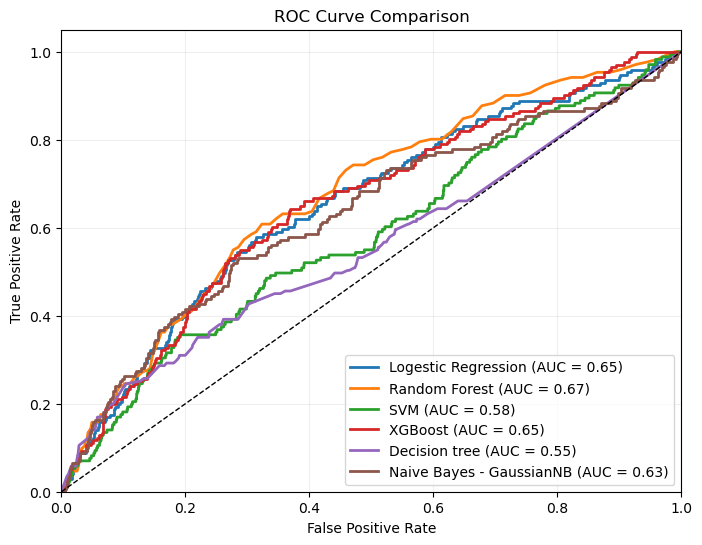

In [95]:
models_proba = {
    'Logestic Regression' : logreg_grid_proba,
    'Random Forest': rf_grid_proba,
     'SVM': svm_proba,
     'XGBoost': xgb_grid_proba,
     'Decision tree': dt_proba,
     'Naive Bayes - GaussianNB' : nb_proba   
}

plt.figure(figsize=(8, 6))

for model_name, proba in models_proba.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)

plt.show()


Observations:

Best performer:
Random Forest (AUC = 0.67) — Highest AUC value among all, suggesting the best discriminatory ability.

Close contenders:
Logistic Regression and XGBoost (AUC = 0.65) — Also perform reasonably well.

Moderate performance:
Naive Bayes (GaussianNB) (AUC = 0.63)

Lower performers:
SVM (AUC = 0.58)
Decision Tree (AUC = 0.55) — Barely above the diagonal, which represents random guessing.

Summary:
All models perform above random guessing (AUC > 0.5), though some only marginally.

Random Forest and XGBoost are generally strong performers in ensemble learning tasks, which aligns with their higher AUC values here.


2. TOMEK Trained

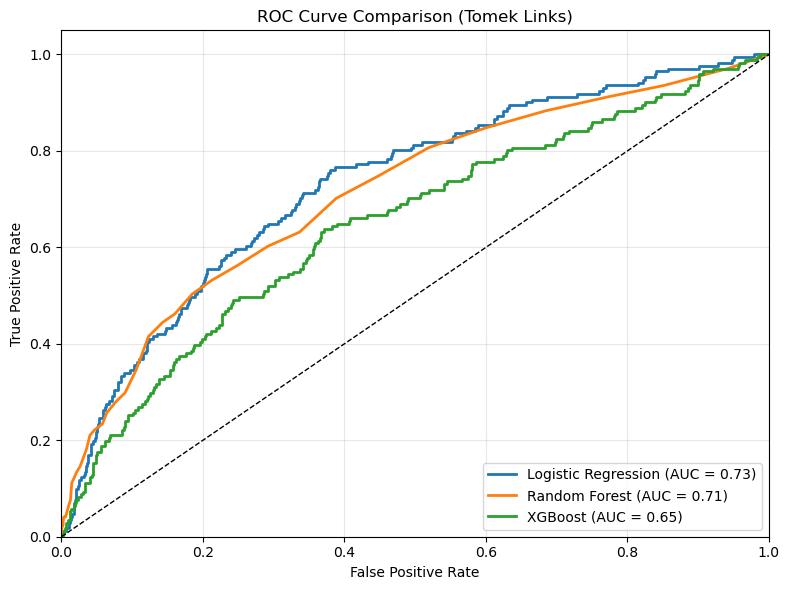

In [99]:
models_proba = {
    'Logistic Regression': logreg_tl.predict_proba(X_test)[:, 1],
    'Random Forest': rf_tl.predict_proba(X_test)[:, 1],
    'XGBoost': xgb_tl.predict_proba(X_test)[:, 1]
}

plt.figure(figsize=(8, 6))

for model_name, proba in models_proba.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Random guessing diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Axis settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Tomek Links)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Logistic Regression has the best performance among the three.

Random Forest is close behind.

XGBoost has the lowest performance in this comparison.

Predict using your best model

In [121]:
sample_inputs = pd.DataFrame([
    {        
        'age_max': 0.85,
        'REQUESTED_TENURE': 0.20,
        'LTV_sq': 0.40,
        'LOG_income_sum': 2.5,
        'open_TL_ratio': 0.3,
        'has_delinquency': 0,
        'SAL_FLAG': 1,
        'active_loans': 1,
        'Loan_sub_type_1': 1,
        'enquiry_risk': 1,
        'Bureau_prd_grouped': 1,
        'Doc_form_16': 1,
        'HAS_INSURANCE': 1,
        'emi_stress_flag': 0,
        'CHANNEL_CODE_GROUPED': 0
    },
    {
        
        'age_max': 0.6,
        'REQUESTED_TENURE': 0.5,
        'LTV_sq': 0.7,
        'LOG_income_sum': 1.7,
        'open_TL_ratio': -0.2,
        'has_delinquency': 1,
        'SAL_FLAG': 0,
        'active_loans': 2,
        'Loan_sub_type_1': 2,
        'enquiry_risk': 2,
        'Bureau_prd_grouped': 2,
        'Doc_form_16': 0,
        'HAS_INSURANCE': 0,
        'emi_stress_flag': 1,
        'CHANNEL_CODE_GROUPED': 1
    },
    {
        
        'age_max': 0.4,
        'REQUESTED_TENURE': 0.8,
        'LTV_sq': 0.9,
        'LOG_income_sum': 1.2,
        'open_TL_ratio': -0.8,
        'has_delinquency': 1,
        'SAL_FLAG': 0,
        'active_loans': 4,
        'Loan_sub_type_1': 3,
        'enquiry_risk': 3,
        'Bureau_prd_grouped': 3,
        'Doc_form_16': 0,
        'HAS_INSURANCE': 0,
        'emi_stress_flag': 1,
        'CHANNEL_CODE_GROUPED': 2
    }
])

print(sample_inputs)

   age_max  REQUESTED_TENURE  LTV_sq  LOG_income_sum  open_TL_ratio  \
0     0.85               0.2     0.4             2.5            0.3   
1     0.60               0.5     0.7             1.7           -0.2   
2     0.40               0.8     0.9             1.2           -0.8   

   has_delinquency  SAL_FLAG  active_loans  Loan_sub_type_1  enquiry_risk  \
0                0         1             1                1             1   
1                1         0             2                2             2   
2                1         0             4                3             3   

   Bureau_prd_grouped  Doc_form_16  HAS_INSURANCE  emi_stress_flag  \
0                   1            1              1                0   
1                   2            0              0                1   
2                   3            0              0                1   

   CHANNEL_CODE_GROUPED  
0                     0  
1                     1  
2                     2  


In [123]:
for i, row in sample_inputs.iterrows():
    sample = row.to_frame().T  # Convert Series to single-row DataFrame
    pred = rf_grid.best_estimator_.predict(sample)[0]
    proba = rf_grid.best_estimator_.predict_proba(sample)[:, 1][0]
    print(f"Sample {i+1} : Prediction:, {pred}, Probability of Default: {proba}")             

Sample 1 : Prediction:, 0, Probability of Default: 0.18
Sample 2 : Prediction:, 0, Probability of Default: 0.36
Sample 3 : Prediction:, 0, Probability of Default: 0.305
